# Combining results with asymmetric errors

When sample sizes are small and models very non-linear, the likelihood around the minimum is not well approximated by a parabola. In that case, the errors computed by the profile likelihood method (MINOS errors in MINUIT) are asymmetric and differ from the errors computed from inverting the Hesse matrix of the log-likelihood at the minimum (HESSE errors in MINUIT). If the asymmetry is not dramatic, it is better to report the symmetric HESSE errors, since these cause much less pain down the line. If the asymmetry is very pronounced, however, it is more meaningful to publish an asymmetric uncertainty interval.

Asymmetric errors are a pain for anyone who wants to use the result, however. The combination of asymmetric errors is not well-defined as there is missing information. The mathematically sound procedure is to construct a likelihood function from the value and the asymmetric errors and then add the log-likelihoods together and compute a new value with uncertainties from that. Alas, there are infinitely many ways to construct an asymmetric likelihood from three points.

One has to make assumptions. Roger Barlow has written [several](https://arxiv.org/abs/physics/0401042) [papers](https://arxiv.org/abs/physics/0406120) about this topic. A very nice overview about this and many other topics given in [Practical statistics for particle physics](https://arxiv.org/pdf/1905.12362). He also published code to demonstrate the combination on [Github](https://github.com/RogerJBarlow/Asymmetric-Errors).

In this notebook we follow his ideas and show how to combine results in Python with iminuit.

In [77]:
from iminuit import Minuit
from enum import Enum
from numpy.typing import ArrayLike
import numpy as np

Roger constructs the asymmetric log-likelihood for an observation $x$ from a Gaussian where either the width $\sigma$ or the variance $\sigma^2$ is a linear function of the deviation $(x - \mu)$, where $\mu$ is the unknown true value. The first kind works well when the value $x$ and is the logarithm of quantity which has symmetric uncertainties. The second kind works well if $x$ is proportional to a Poisson-distributed value, in other words, it is a scaled result of a counting experiment.

Here is an asymptotically chi2-distributed cost function which can do both interpolations for N measurements.

In [86]:
AsymKind = Enum("AsymKind", ["POISSON", "LOGX"])


def chi2_asym(x: ArrayLike, d: ArrayLike, u: ArrayLike, mu: ArrayLike, kind : AsymKind) -> float:
    # formulas taken from Roger Barlow, https://arxiv.org/pdf/1905.12362
    x = np.atleast_1d(x)
    # d is allowed to be negative
    d = np.abs(np.atleast_1d(d))
    u = np.atleast_1d(u)
    dx = x - mu
    if kind == AsymKind.POISSON:
        v = u * d
        vp = u - d
        # make sure that variance does not become negative
        den = np.maximum(v - vp * dx, 1e-100)
    elif kind == AsymKind.LOGX:
        s = 2 * u * d / (u + d)
        sp = (u - d) / (u + d)
        # make sure that sigma does not become negative
        den = np.maximum(s - sp * dx, 1e-100)
        den **= 2
    else:
        msg = f"unknown AsymKind {kind}"
        raise ValueError(msg)
    return np.sum(dx ** 2 / den)

Now we use this to combine three measurements: $1.9_{-0.5}^{+0.7}$, $2.4_{-0.8}^{+0.6}$, $3.1_{-0.4}^{+0.5}$ using LOGX interpolation. We put them into the cost function and minimize it with iminuit. We obtain $2.76_{-0.27}^{+0.29}$. As expected from the Central Limit Theorem, the combination of independent measurements yields a quantity which closer to a normal distributed than the individual measurements. The confidence interval (computed with MINOS) for the combined quantity is therefore more symmetric.

In [87]:
def chi2(mu):
    return chi2_asym(
        [1.9, 2.4, 3.1], [0.5, 0.8, 0.4], [0.7, 0.6, 0.5], mu, AsymKind.LOGX
    )


chi2.errordef = 1
chi2.ndata = 3

m = Minuit(chi2, 2)
m.migrad()
m.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.422 (χ²/ndof = 1.2)      │              Nfcn = 26               │
│ EDM = 1.95e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu   │   2.76    │   0.28    │   -0.27    │    0.29    │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┐
│          │          mu           │
├──────────┼───────────┬───────────┤
│  Error   │   -0.27   │   0.29    │
│  Valid   │   True    │   True    │
│ At Limit │   False   │   False   │
│ Max FCN  │   False   │   False   │
│ New Min  │   False   │   False   │
└──────────┴───────────┴───────────┘
┌────┬────────┐
│    │     mu │
├────┼────────┤
│ mu │ 0.0804 │
└────┴────────┘

An almost identical result is obtained with POISSON interpolation: $2.75_{-0.26}^{+0.29}$.

In [ ]:
def chi2(mu):
    return chi2_asym(
        [1.9, 2.4, 3.1], [0.5, 0.8, 0.4], [0.7, 0.6, 0.5], mu, AsymKind.POISSON
    )


chi2.errordef = 1
chi2.ndata = 3

m = Minuit(chi2, 2)
m.migrad()
m.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.43 (χ²/ndof = 1.2)       │              Nfcn = 24               │
│ EDM = 8.77e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu   │   2.75    │   0.28    │   -0.26    │    0.29    │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┐
│          │          mu           │
├──────────┼───────────┬───────────┤
│  Error   │   -0.26   │   0.29    │
│  Valid   │   True    │   True    │
│ At Limit │   False   │   False   │
│ Max FCN  │   False   │   False   │
│ New Min  │   False   │   False   │
└──────────┴───────────┴───────────┘
┌────┬────────┐
│    │     mu │
├────┼────────┤
│ mu │ 0.0765 │
└────┴────────┘

If the correct kind of interpolation is unknown, one should consider this variation as a systematic uncertainty.

We can see below that the chi-square functions with the two kinds of interpolation in fact look very similar. One should not expect either interpolation to work well far from the minimum.

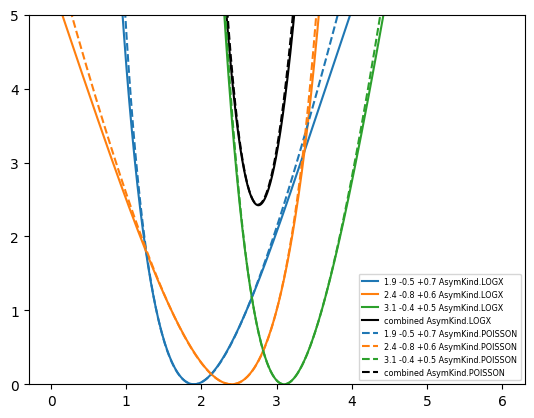

In [103]:
from matplotlib import pyplot as plt
import numpy as np

mu = np.linspace(0, 6, 1000)
for kind in (AsymKind.LOGX, AsymKind.POISSON):
    ls = {AsymKind.LOGX: "-", AsymKind.POISSON: "--"}[kind]
    for i, (x, d, u) in enumerate(((1.9, -0.5, 0.7), (2.4, -0.8, 0.6), (3.1, -0.4, 0.5))):
            plt.plot(mu, np.vectorize(lambda mu: chi2_asym(x, d, u, mu, kind))(mu), color=f"C{i}", ls=ls, label=f"{x} {d:+} {u:+} {kind}")
    plt.plot(mu, np.vectorize(lambda mu: chi2_asym(
        [1.9, 2.4, 3.1], [0.5, 0.8, 0.4], [0.7, 0.6, 0.5], mu, kind
    ))(mu), color="k", ls=ls, label=f"combined {kind}")
plt.legend(fontsize="xx-small")
plt.ylim(0, 5);